<a href="https://colab.research.google.com/github/Shrondi/smart-bridges/blob/main/fix_data_smartbridges.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Introducción

Los **acelerómetros** instalados en los puentes presentan un problema al volcar los datos en la base de datos: los ejes aparecen intercambiados.

Inicialmente, se intentó esquivar este error mediante una consulta `SELECT` en SQL que solucionaba el problema cada vez que se hacía una consulta. Sin embargo, debido a su lentitud y complejidad, se decidió implementar una solución más eficiente y definitiva: desarrollar un **algoritmo** capaz de detectar automáticamente los **intercambios** de ejes y corregir los datos directamente en la base de datos.

Lo que en un principio parecía un simple error de intercambio de ejes en algunos bloques de datos resultó ser más complejo, ya que se identificaron múltiples tipos de errores en las muestras.

# Planteamiento del problema

## Análisis inicial

Cada puente está conformado por 8 sensores colocados de forma simétrica y repartidos equitativamente a cada lado de las vías.

Cada uno de los acelerómetros esta configurado con unos determinados parámetros: frecuencia, escala y tamaño de la palabra.

Cada una de las muestras de los acelerómetros contiene una medición en crudo de los ejes z, x e y. Un conjunto de muestras a una determinada frecuencia forma un datablock.



Como se observó a posteriori, los acelerómetros intercambiaban en las muestras los datos de los ejes z, x e y de forma aleatoria y sin ningún patrón aparente.

Por tanto, era necesario arreglar las muestras y datablocks que presentaban algún tipo de problema por cada uno de los acelerómetros.

## Errores y filtrado

El análisis de los datos de los acelerómetros reveló que los errores no se limitaban únicamente al intercambio de ejes en algunos bloques de datos, sino que eran más variados:

* **Outliers**: dentro de un bloque de datos, se encontraba una única muestra con un valor absurdo en alguno de sus ejes.

* **Muestras erróneas**: algunos bloques de datos contenían valores incorrectos en sus últimas muestras, generalmente 0.0, 0.25 o 1.0. En comparación con las muestras correctas, estos valores eran claramente anormales.

* **Intercambio completo de ejes**: En ciertos bloques, los ejes estaban completamente intercambiados, por ejemplo, (Z, X, Y) o (X, Y, Z).

* **Intercambio parcial de ejes**: La mayoría de los bloques presentaban sus últimas muestras con los ejes intercambiados, generalmente después de haber registrado errores del tipo anterior.

Previamente, para determinar qué datablocks eran erróneos y cuáles eran correctos, era necesario definir un criterio de filtrado:  

Se calcula la media aritmética de cada eje por datablock, y aquellos datablocks cuyos valores estuvieran fuera del intervalo:  

$
\mu \pm (\tau \cdot \sigma)
$

se consideraban erróneos.  

Donde:  
- $\mu$ representa la media del datablock.
- $\tau$ representa un umbral (threshold).  
- $\sigma$ representa la desviación estándar del datablock


## Intercambio de ejes

La solución del intercambio de ejes esta formado por dos etapas:
1. Analizar los datablocks para buscar aquellas muestras con ejes intercambiados.
2. Analizar los datablocks de forma completa e intercambiar sus ejes.

Para el primer caso, se recorre cada uno de los datablocks y se comparaban los ejes de la muestra actual con la anterior para determinar si ha habido un intercambio (Y, X, Z) o (Z, X, Y)

```
Algoritmo fix_samples_datablocks
    Filtrar datos eliminando filas con menos de 3 decimales en x, y o z

    Para cada grupo de datos agrupados por 'data_block' hacer
        Para cada fila en el grupo desde la segunda hasta la última hacer
            prev_row = Fila anterior
            row = Fila actual
            
            // Verificar si los ejes están intercambiados
            Si ejes (Z, X, Y) entonces
                Intercambiar x = z en la fila actual
                Intercambiar x = y en la fila actual

                Ejecutar consulta UPDATE SQL

            Sino ejes (Y, Z, X) entonces
                Intercambiar y = z en la fila actual
                Intercambiar x = y en la fila actual

                Ejecutar consulta UPDATE SQL

            Fin Si
          Fin Para
      Fin Para

Fin Algoritmo
```

Para el segundo caso, se calcula la media de cada uno de los ejes de cada datablock, y se recorren los datablock comparando las medias de cada uno de los ejes del datablock actual con las medias de los ejes del datablock anterior para determinar si ha habido intercambio en los ejes.

```
Algoritmo fix_datablocks

    // Obtener valores únicos de data_block
    data_blocks = obtener_data_blocks_unicos(df_raw)

    // Iterar sobre cada data_block
    Para cada data_block en data_blocks:

        // Obtener el data_block actual y el bloque anterior
        current_data_block = data_block
        prev_data_block = obtener_bloque_anterior()

        // Obtener las medias de los ejes para el bloque actual y el bloque anterior (si existe)
        current_means = obtener_medias_ejes()
        prev_block_means = obtener_medias_ejes() si prev_data_block existe

        Si prev_block_means existe:

            Si ejes (Z, X, Y):

                Ejecutar consulta UPDATE SQL

            Sino si ejes (Y, Z, X):

                Ejecutar consulta UPDATE SQL

            Fin Si

        Fin Si

      Fin Para

Fin Algoritmo
```

Cabe destacar, que previamente hay que limpiar las muestras erróneas de los datablock para que así las medias no salgan alteradas y no haya errores a la hora de intercambiar.

## Solución

En resumen, los pasos de la solución adoptada son:
  1. Elegir un acelerómetro y un rango temporal. Preferiblemente no más de un día para evitar problemas de bloqueos o memoria.
  2. Filtrar los datablocks correctos de los erróneos.
  3. Obtener la media de cada eje para todos los datablocks erróneos.
  4. Eliminar las muestras erróneas de los databloks.
  5. Iterar sobre cada datablock para corregir el intercambio de los ejes en las muestras.
  6. Recorrer los datablocks para corregir sus ejes.

# Código

## Importación e instalación

In [ ]:
# Acelerómetros:
# ADXL355, 20bits, +-2g, 125Hz:  https://www.analog.com/media/en/technical-documentation/data-sheets/adxl354_adxl355.pdf

!pip install -q mysql-connector-python mysqlclient
!pip install -q pandas
!pip install -q matplotlib
!pip install -q plotly

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 91.4/91.4 kB 8.3 MB/s eta 0:00:00
  Installing build dependencies ... done
  Getting requirements to build wheel ... done
  Preparing metadata (pyproject.toml) ... done
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 34.0/34.0 MB 58.8 MB/s eta 0:00:00


In [ ]:
import mysql.connector
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np

## Definición funciones

### Funciones BD

In [ ]:
def get_stats_datablocks(accelerometer, datetime_init, datetime_end):

  """ Obtención de la media aritmética de los ejes de cada bloque de datos """

  querystr = f"""\
    SELECT
          da.data_block,
          AVG(axisx) AS avg_x,
          AVG(axisy) AS avg_y,
          AVG(axisz) AS avg_z
      FROM data_accelerometer da
      JOIN data_block db ON da.data_block = db.id
      JOIN configuration_acc ca ON ca.id = db.configuration
      JOIN accelerometer ac ON ac.sensor = ca.accelerometer
      JOIN chip ch ON ch.id = ac.chip
      WHERE time_begin BETWEEN '{datetime_init}' AND '{datetime_end}'
        AND ac.sensor = {accelerometer}
      GROUP BY da.data_block
      """

  cursor.execute(querystr)

  return cursor.fetchall()

In [ ]:
def get_datablocks_data(datablocks):

    """ Obtención de los datos de los bloques de datos """
    querystr = f"""
      SELECT
          DATE_ADD(
              time_begin,
              INTERVAL
              (
                  CASE
                      WHEN ca.frequency = 0 THEN 1/31.25
                      ELSE 1/125
                  END
              ) * (
                  SELECT COUNT(*)
                  FROM data_accelerometer da_inner
                  WHERE da_inner.data_block = da.data_block
                  AND da_inner.id <= da.id
              ) - 1
              SECOND_MICROSECOND
          ) AS incrementada,

          axisx * (POW(2, scale+2) / POW(2, word_bits)) AS x,
          axisy * (POW(2, scale+2) / POW(2, word_bits)) AS y,
          axisz * (POW(2, scale+2) / POW(2, word_bits)) AS z,
          da.data_block,
          da.id
      FROM
          data_block db
          JOIN data_accelerometer da ON da.data_block = db.id
          JOIN configuration_acc ca ON ca.id = db.configuration
          JOIN accelerometer ac ON ac.sensor = ca.accelerometer
          JOIN chip ch ON ch.id = ac.chip
      WHERE
      da.data_block IN ({datablocks})
      """

    cursor.execute(querystr)

    return cursor.fetchall()

In [ ]:
def get_acelerometer_data(accelerometer, datetime_init, datetime_end):

  """ Obtención de los datos de los acelerómetros """

    querystr = f"""\
    SELECT
        DATE_ADD(
        time_begin,
        INTERVAL
        (
            CASE
                WHEN ca.frequency = 0 THEN 1/31.25
                ELSE 1/125
            END
        ) * (
            SELECT COUNT(*)
            FROM data_accelerometer da_inner
            WHERE da_inner.data_block = da.data_block
            AND da_inner.id <= da.id
        ) - 1
        SECOND_MICROSECOND
    ) AS incrementada,

    axisx * (POW(2, scale+2) / POW(2, word_bits)) AS x,
	  axisy * (POW(2, scale+2) / POW(2, word_bits)) AS y,
	  axisz * (POW(2, scale+2) / POW(2, word_bits)) AS z

    FROM
        data_block db
        JOIN data_accelerometer da ON da.data_block = db.id
        JOIN configuration_acc ca ON ca.id = db.configuration
        JOIN accelerometer ac ON ac.sensor = ca.accelerometer
        JOIN chip ch ON ch.id = ac.chip
    WHERE
        time_begin BETWEEN '{datetime_init}' AND '{datetime_end}'
        AND ac.sensor = {accelerometer}"""

    cursor.execute(querystr)

    return cursor.fetchall()


### Funciones procesamiento datos

In [ ]:
def plot_acelerometer_data(data, axes=['z', 'y', 'x'], min_date=None, max_date=None):

  df = pd.DataFrame(data, columns=['datetime', 'x', 'y', 'z', 'data_block', 'id'])
  df.set_index('datetime', inplace=True)
  df.sort_values('datetime', inplace=True)

  df = df[['x', 'y', 'z', 'data_block']]

  fig, ax = plt.subplots(figsize=(10, 3))

  # Configurar la escala temporal si se proporcionan min_date y max_date
  if min_date is not None and max_date is not None:
    min_date = pd.to_datetime(min_date)
    max_date = pd.to_datetime(max_date)
    ax.set_xlim(min_date, max_date)

    df = df[(df.index >= min_date) & (df.index <= max_date)]

  # Graficar la aceleración en cada eje
  colors = {'x': 'b', 'y': 'y', 'z': 'g'}
  for axis in axes:
    if axis in df.columns:
      ax.plot(df.index, df[axis], label=axis.upper(), color=colors.get(axis))

  # Configurar el título y las etiquetas de los ejes
  ax.set_title('Accel. data', fontsize=12,fontweight='bold')
  ax.set_xlabel('tiempo', fontsize=12)
  ax.set_ylabel('aceleración [g]', fontsize=12)

  ax.tick_params(axis='x', labelsize=12)

  ax.legend(loc="lower left")

  # Configurar el borde sólido de la zona de representación de datos
  ax.spines['left'].set_linewidth(1)
  ax.spines['bottom'].set_linewidth(1)
  ax.spines['right'].set_linewidth(1)
  ax.spines['top'].set_linewidth(1)

  # Configurar la rejilla de líneas punteadas y semitransparentes
  ax.grid(which='major', linestyle='--', alpha=0.5)
  ax.grid(which='minor', linestyle=':', alpha=0.3)

  plt.show()

  return df

In [ ]:
def filter_datablocks(data, threshold):
    """ Filtrar los datablocks que estén fuera de media ± (threshold * desviación estándar) """

    df = pd.DataFrame(data, columns=['data_block', 'avg_x', 'avg_y', 'avg_z'])
    df.set_index('data_block', inplace=True)

    df = df.astype(float)

    # Guardar todos los data_blocks iniciales
    all_datablocks = df.index.tolist()

    for col in ['avg_x', 'avg_y', 'avg_z']:
      mean = df[col].mean()
      std = df[col].std()
      df = df[(df[col] >= mean - threshold * std) & (df[col] <= mean + threshold * std)]

    # Convertir el índice a una cadena
    good_datablocks_str = ', '.join(map(str, df.index.tolist()))

    # Obtener los data_blocks eliminados
    removed_datablocks = list(set(all_datablocks) - set(df.index.tolist()))
    removed_datablocks_str = ', '.join(map(str, removed_datablocks))

    return good_datablocks_str, removed_datablocks_str

In [ ]:
def fix_samples_datablocks(bad_data, THRESHOLD_FIX_SAMPLES, ACELEROMETRO, FECHA_HORA_INICIO, FECHA_HORA_FIN):
    """
    Analiza las muestras de los datablocks intercambiando los ejes de las muestras que lo requieran.
    Además, elimina aquellas muestras que tengan una precisión decimal menor a 3 decimales (muestras erróneas)

    Return:
        DataFrame con los datos arreglados
    """

    # Convertir bad_data a Pandas DataFrame
    df = pd.DataFrame(bad_data, columns=['datetime', 'x', 'y', 'z', 'data_block', 'id'])

    # Eliminar filas con baja precisión decimal (menos de 3 decimales)
    df = df[df['x'].apply(lambda x: len(str(x).split('.')[1]) >= 3) & \
            df['y'].apply(lambda x: len(str(x).split('.')[1]) >= 3) & \
            df['z'].apply(lambda x: len(str(x).split('.')[1]) >= 3)]


    def correct_axes(group):
      """ Función para corregir los ejes de las muestras que lo requieran de un datablock """

        for i in range(1, len(group)):
            prev_row = group.iloc[i - 1]
            row = group.iloc[i]

            # Condición de ejes intercambiados
            ejes_intercambiadosA = (
                (np.abs(float(row['x'])) >= np.abs(float(prev_row['z'])) - THRESHOLD_FIX_SAMPLES) and (np.abs(float(row['x'])) <= np.abs(float(prev_row['z'])) + THRESHOLD_FIX_SAMPLES) and
                (np.abs(float(row['y'])) >= np.abs(float(prev_row['x'])) - THRESHOLD_FIX_SAMPLES) and (np.abs(float(row['y'])) <= np.abs(float(prev_row['x'])) + THRESHOLD_FIX_SAMPLES) and
                (np.abs(float(row['z'])) >= np.abs(float(prev_row['y'])) - THRESHOLD_FIX_SAMPLES) and (np.abs(float(row['z'])) <= np.abs(float(prev_row['y'])) + THRESHOLD_FIX_SAMPLES)
            )

            ejes_intercambiadosB = (
                (np.abs(float(row['x'])) >= np.abs(float(prev_row['y'])) - THRESHOLD_FIX_SAMPLES) and (np.abs(float(row['x'])) <= np.abs(float(prev_row['y'])) + THRESHOLD_FIX_SAMPLES) and
                (np.abs(float(row['y'])) >= np.abs(float(prev_row['z'])) - THRESHOLD_FIX_SAMPLES) and (np.abs(float(row['y'])) <= np.abs(float(prev_row['z'])) + THRESHOLD_FIX_SAMPLES) and
                (np.abs(float(row['z'])) >= np.abs(float(prev_row['x'])) - THRESHOLD_FIX_SAMPLES) and (np.abs(float(row['z'])) <= np.abs(float(prev_row['x'])) + THRESHOLD_FIX_SAMPLES)
            )


            row_id = row['id']

            # Intercambiar ejes solo para la muestra actual si se detecta un intercambio de ejes
            if ejes_intercambiadosA:

                # Intercambiar X y Z
                group.loc[group.index[i], ['x', 'z']] = group.loc[group.index[i], ['z', 'x']].values
                # Intercambiar X e Y
                group.loc[group.index[i], ['x', 'y']] = group.loc[group.index[i], ['y', 'x']].values

                update_query = f"""
                UPDATE data_accelerometer
                SET axisx = {row['y']}, axisy = {row['z']}, axisz = {row['x']}
                WHERE id = {row_id}
                """
                cursor.execute(update_query)
                db.commit()

                print(update_query)

            elif ejes_intercambiadosB:

                # Intercambiar Y y Z
                group.loc[group.index[i], ['y', 'z']] = group.loc[group.index[i], ['z', 'y']].values
                # Intercambiar Y e X
                group.loc[group.index[i], ['x', 'y']] = group.loc[group.index[i], ['y', 'x']].values

                update_query = f"""
                UPDATE data_accelerometer
                SET axisx = {row['z']}, axisy = {row['x']}, axisz = {row['y']}
                WHERE id = {row_id}
                """

                cursor.execute(update_query)
                db.commit()

                print(update_query)

        return group

    # Aplicar la función por cada datablock
    df = df.groupby('data_block').apply(correct_axes).reset_index(drop=True)

    # 2. Construir la consulta SQL para eliminar datos con baja precisión decimal
    delete_query = f"""
    DELETE da FROM data_accelerometer da
    JOIN data_block db ON da.data_block = db.id
    JOIN configuration_acc ca ON ca.id = db.configuration
    JOIN accelerometer ac ON ac.sensor = ca.accelerometer
    JOIN chip ch ON ch.id = ac.chip
    WHERE (LENGTH(SUBSTR(axisx * (POW(2, scale+2) / POW(2, word_bits)), INSTR(axisx * (POW(2, scale+2) / POW(2, word_bits)), '.') + 1)) < 3
          OR LENGTH(SUBSTR(axisy * (POW(2, scale+2) / POW(2, word_bits)), INSTR(axisy * (POW(2, scale+2) / POW(2, word_bits)), '.') + 1)) < 3
          OR LENGTH(SUBSTR(axisz * (POW(2, scale+2) / POW(2, word_bits)), INSTR(axisz * (POW(2, scale+2) / POW(2, word_bits)), '.') + 1)) < 3)
      AND ac.sensor = {ACELEROMETRO}
      AND db.time_begin BETWEEN '{FECHA_HORA_INICIO}' AND '{FECHA_HORA_FIN}';
    """

    cursor.execute(delete_query)
    db.commit()

    return df

In [ ]:
def fix_datablocks(datablock_raw, THRESHOLD_FIX_DATABLOCKS):
    """
    Arregla los datablocks intercambiando sus ejes usando la media por cada eje para
    comparar con la media del bloque anterior.

    Returns:
        Un DataFrame que representan los datos de los datablocks arreglados.
    """

    # Convertir datablock_raw a Pandas DataFrame
    df_raw = pd.DataFrame(datablock_raw, columns=['data_block', 'avg_x', 'avg_y', 'avg_z'])
    df_raw.set_index('data_block', inplace=True)

    df_raw = df_raw.astype(float)

    # Get unique data_block values
    data_blocks = df_raw.index.unique()

    # Iterate over data_blocks
    for i in range(len(data_blocks)):
        current_data_block = data_blocks[i]
        prev_data_block = data_blocks[i - 1] if i > 0 else None  # Get previous block if available

        # Get current and previous block means
        current_means = df_raw.loc[current_data_block, ['avg_x', 'avg_y', 'avg_z']]
        prev_block_means = df_raw.loc[prev_data_block, ['avg_x', 'avg_y', 'avg_z']] if prev_data_block is not None and prev_data_block in df_raw.index else None

        # Compara las medias con las del bloque anterior (si está disponible)
        if prev_block_means is not None:
            # Condición de ejes intercambiados (utilizando la media)
            ejes_intercambiadosA = (
                (np.abs(float(current_means['avg_x'])) >= np.abs(float(prev_block_means['avg_z'])) - THRESHOLD_FIX_DATABLOCKS) and (np.abs(float(current_means['avg_x'])) <= np.abs(float(prev_block_means['avg_z'])) + THRESHOLD_FIX_DATABLOCKS) and
                (np.abs(float(current_means['avg_y'])) >= np.abs(float(prev_block_means['avg_x'])) - THRESHOLD_FIX_DATABLOCKS) and (np.abs(float(current_means['avg_y'])) <= np.abs(float(prev_block_means['avg_x'])) + THRESHOLD_FIX_DATABLOCKS) and
                (np.abs(float(current_means['avg_z'])) >= np.abs(float(prev_block_means['avg_y'])) - THRESHOLD_FIX_DATABLOCKS) and (np.abs(float(current_means['avg_z'])) <= np.abs(float(prev_block_means['avg_y'])) + THRESHOLD_FIX_DATABLOCKS)
            )

            ejes_intercambiadosB = (
                (np.abs(float(current_means['avg_x'])) >= np.abs(float(prev_block_means['avg_y'])) - THRESHOLD_FIX_DATABLOCKS) and (np.abs(float(current_means['avg_x'])) <= np.abs(float(prev_block_means['avg_y'])) + THRESHOLD_FIX_DATABLOCKS) and
                (np.abs(float(current_means['avg_y'])) >= np.abs(float(prev_block_means['avg_z'])) - THRESHOLD_FIX_DATABLOCKS) and (np.abs(float(current_means['avg_y'])) <= np.abs(float(prev_block_means['avg_z'])) + THRESHOLD_FIX_DATABLOCKS) and
                (np.abs(float(current_means['avg_z'])) >= np.abs(float(prev_block_means['avg_x'])) - THRESHOLD_FIX_DATABLOCKS) and (np.abs(float(current_means['avg_z'])) <= np.abs(float(prev_block_means['avg_x'])) + THRESHOLD_FIX_DATABLOCKS)
            )

            # Intercambiar los valores medios si se detecta un intercambio
            if ejes_intercambiadosA:
                # Intercambiar X y Z
                df_raw.loc[current_data_block, ['avg_x', 'avg_z']] = df_raw.loc[current_data_block, ['avg_z', 'avg_x']].values
                # Intercambiar X e Y (ahora Y es el original X)
                df_raw.loc[current_data_block, ['avg_x', 'avg_y']] = df_raw.loc[current_data_block, ['avg_y', 'avg_x']].values

                update_query = f"""
                UPDATE data_accelerometer AS d
                JOIN (
                    SELECT id, axisx AS old_axisx, axisy AS old_axisy, axisz AS old_axisz
                    FROM data_accelerometer
                    WHERE data_block = {current_data_block}
                ) AS temp
                ON d.id = temp.id
                SET d.axisx = temp.old_axisy,
                    d.axisy = temp.old_axisz,
                    d.axisz = temp.old_axisx
                WHERE d.data_block = {current_data_block};

                """

                # Ejecutar la consulta SQL
                cursor.execute(update_query)
                db.commit()  # Confirmar los cambios en la base de datos
                print(update_query)

            elif ejes_intercambiadosB:
                # Intercambiar Y y Z
                df_raw.loc[current_data_block, ['avg_y', 'avg_z']] = df_raw.loc[current_data_block, ['avg_z', 'avg_y']].values
                # Intercambiar X e Y (ahora Y es el original X)
                df_raw.loc[current_data_block, ['avg_x', 'avg_y']] = df_raw.loc[current_data_block, ['avg_y', 'avg_x']].values

                update_query = f"""
                UPDATE data_accelerometer AS d
                JOIN (
                    SELECT id, axisx AS old_axisx, axisy AS old_axisy, axisz AS old_axisz
                    FROM data_accelerometer
                    WHERE data_block = {current_data_block}
                ) AS temp
                ON d.id = temp.id
                SET d.axisx = temp.old_axisz,
                    d.axisy = temp.old_axisx,
                    d.axisz = temp.old_axisy
                WHERE d.data_block = {current_data_block};

                """

                # Ejecutar la consulta SQL
                cursor.execute(update_query)
                db.commit()  # Confirmar los cambios en la base de datos
                print(update_query)

    return df_raw  # Return the modified DataFrame

## Variables

In [ ]:
MYSQL_HOST = '79.116.81.120'
MYSQL_DATABASE = 'smart-bridges'
MYSQL_USER = 'user'
MYSQL_PASSWORD = 'e5iLFLqq54t7fc(s'

FECHA_HORA_INICIO        = '2025-03-01 00:00:00'
FECHA_HORA_FIN           = '2025-03-02 00:00:00'
ACELEROMETRO             = 4
THRESHOLD_FILTER         = 2                     # Se usa para filtrar los datablocks buenos de los erroneos en la funcion filter_datablocks: media ± (threshold * desviación estándar)
THRESHOLD_FIX_DATABLOCKS = 50                    # Diferencia entre medias de los ejes de los datablocks (Las medias estan calculadas sobre los datos raw de los sensores)
THRESHOLD_FIX_SAMPLES    = 0.2                   # Diferencia entre aceleraciones de los ejes entre distintas muestras dentro de un mismo datablock

## Datos sin arregl

In [ ]:
try:
  db = mysql.connector.connect(
    host = MYSQL_HOST,
    user = MYSQL_USER,
    password = MYSQL_PASSWORD,
    database = MYSQL_DATABASE
  )

  db.start_transaction()
  cursor = db.cursor()
  print("Conexión a la BBDD ok")

except Exception as e:
  print("Error al conectar a la BBDD: ", e)

Conexión a la BBDD ok


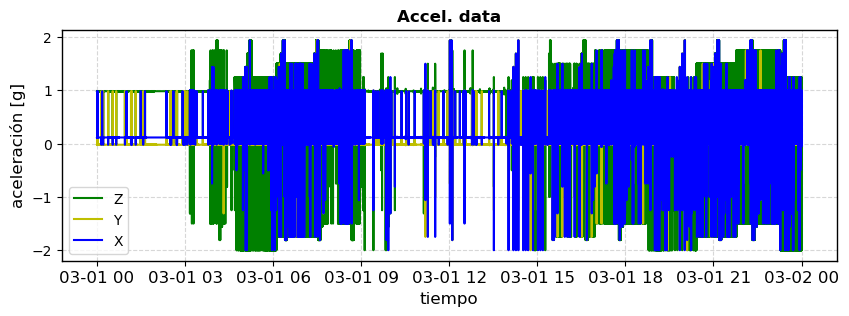

,x,y,z,data_block
datetime,,,,
2025-02-28 23:59:59.142464,0.115997,-0.020130,0.984203,3299259
2025-02-28 23:59:59.150464,0.115795,-0.020096,0.984169,3299259
2025-02-28 23:59:59.158464,0.115715,-0.020149,0.984272,3299259
2025-02-28 23:59:59.166464,0.115906,-0.019989,0.984348,3299259
2025-02-28 23:59:59.174464,0.115822,-0.020119,0.984104,3299259
...,...,...,...,...
2025-03-01 23:59:59.150136,0.116001,-0.020012,0.984180,4058658
2025-03-01 23:59:59.158136,0.116062,-0.020020,0.984215,4058658
2025-03-01 23:59:59.166136,0.115952,-0.020237,0.984219,4058658


In [ ]:
df_data_raw = get_data(ACELEROMETRO, FECHA_HORA_INICIO, FECHA_HORA_FIN) # Datos sin procesar
plot_data(df_data_raw) # Mostrar los datos antes del procesamiento

# Procesamiento de datos

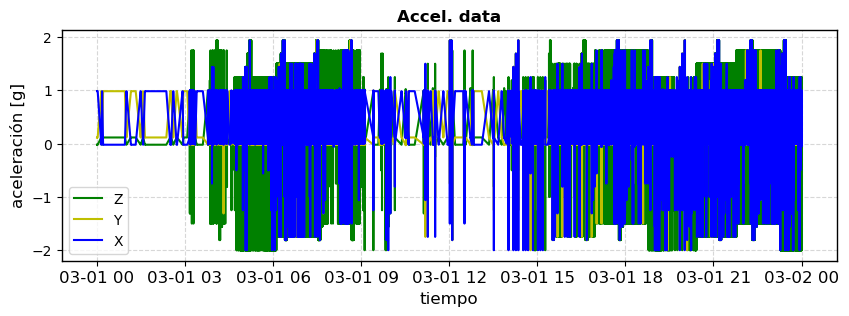

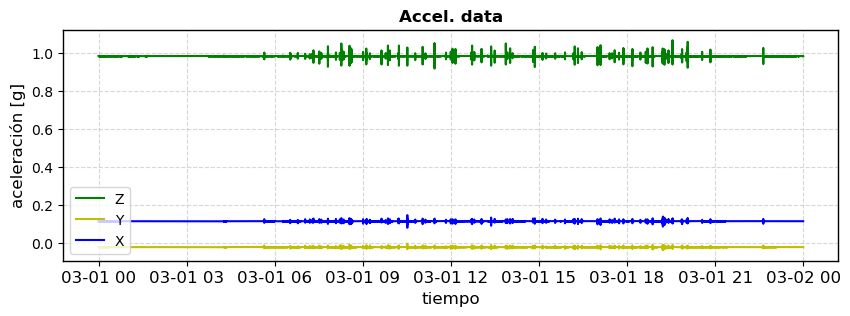

In [ ]:
datablock_stats = get_stats_datablocks(ACELEROMETRO, FECHA_HORA_INICIO, FECHA_HORA_FIN) # Obtener la media de cada eje por datablock

str_datablocks_good, str_datablocks_bad = filter_datablocks(datablock_stats, THRESHOLD_FILTER) # Filtrar datablocks que estén fuera de media ± (threshold * desviación estándar)

good_data = get_datablocks_data(str_datablocks_good) # Obtener los datos de los datablocks sanos
bad_data = get_datablocks_data(str_datablocks_bad) # Obtener los datos de los datablocks para arreglar

df_bad_data = plot_acelerometer_data(bad_data)
df_good_data = plot_acelerometer_data(good_data)

Se han truncado las últimas 5000 líneas del flujo de salida.

                UPDATE data_accelerometer
                SET axisx = 0.11599349975585938, axisy = -0.0200653076171875, axisz = 0.9842147827148438
                WHERE id = 111607830
                

                UPDATE data_accelerometer
                SET axisx = 0.11590194702148438, axisy = -0.020015716552734375, axisz = 0.9839553833007812
                WHERE id = 111607831
                

                UPDATE data_accelerometer
                SET axisx = 0.11598587036132812, axisy = -0.02007293701171875, axisz = 0.9839324951171875
                WHERE id = 111607832
                

                UPDATE data_accelerometer
                SET axisx = 0.11606979370117188, axisy = -0.02022552490234375, axisz = 0.9839744567871094
                WHERE id = 111607833
                

                UPDATE data_accelerometer
                SET axisx = 0.115936279296875, axisy = -0.02010345458984375, axisz =

/tmp/ipykernel_177082/3464387567.py:81: DeprecationWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.
  df = df.groupby('data_block').apply(correct_axes).reset_index(drop=True)


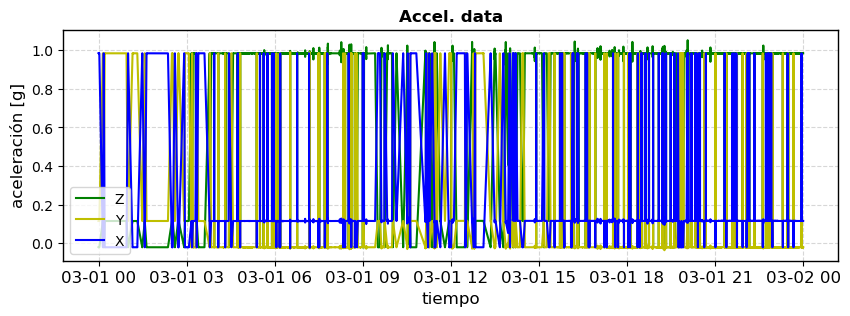

,x,y,z,data_block
datetime,,,,
2025-03-01 00:00:08.142464,0.984474,0.115868,-0.020126,3299349
2025-03-01 00:00:08.150464,0.984226,0.115875,-0.020184,3299349
2025-03-01 00:00:08.158464,0.984188,0.115829,-0.020252,3299349
2025-03-01 00:00:08.166464,0.984344,0.115883,-0.020226,3299349
2025-03-01 00:00:08.174464,0.984364,0.115711,-0.020287,3299349
...,...,...,...,...
2025-03-01 23:59:58.166136,0.116005,-0.020237,0.984299,4058653
2025-03-01 23:59:58.174136,0.115990,-0.020119,0.984165,4058653
2025-03-01 23:59:58.182136,0.115932,-0.020138,0.984241,4058653


In [ ]:
# Se han limpiado aquellos datablocks que tenian solo algunas muestras erroneas o cambiados los ejes

fixed_samples_data = fix_samples_datablocks(bad_data, THRESHOLD_FIX_SAMPLES, ACELEROMETRO, FECHA_HORA_INICIO, FECHA_HORA_FIN)
plot_acelerometer_data(fixed_samples_data) # Datablocks mejorados

In [ ]:
# Arreglar datablocks que todas sus muestras tengan los ejes intercambiados

datablock_stats = get_stats_datablocks(ACELEROMETRO, FECHA_HORA_INICIO, FECHA_HORA_FIN) # Obtener nuevamente los datablocks para recalcular las nuevas medias
datablock_fixed_stats = fix_datablocks(datablock_stats, THRESHOLD_FIX_DATABLOCKS)


                UPDATE data_accelerometer AS d
                JOIN (
                    SELECT id, axisx AS old_axisx, axisy AS old_axisy, axisz AS old_axisz
                    FROM data_accelerometer
                    WHERE data_block = 3525399
                ) AS temp
                ON d.id = temp.id
                SET d.axisx = temp.old_axisz,
                    d.axisy = temp.old_axisx,
                    d.axisz = temp.old_axisy
                WHERE d.data_block = 3525399;

                

                UPDATE data_accelerometer AS d
                JOIN (
                    SELECT id, axisx AS old_axisx, axisy AS old_axisy, axisz AS old_axisz
                    FROM data_accelerometer
                    WHERE data_block = 3545977
                ) AS temp
                ON d.id = temp.id
                SET d.axisx = temp.old_axisz,
                    d.axisy = temp.old_axisx,
                    d.axisz = temp.old_axisy
                WHERE d.data_block = 3

# Datos finales

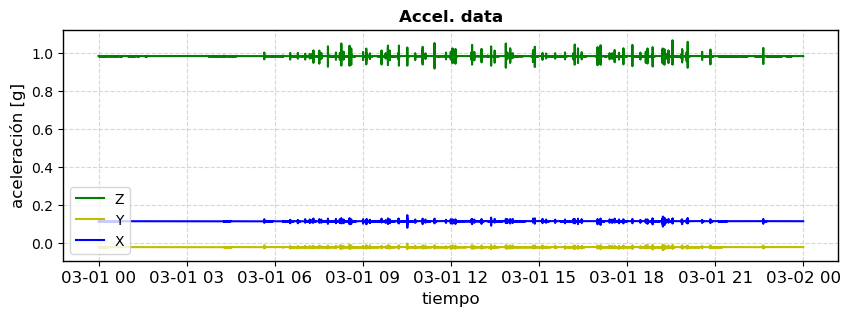

In [ ]:
# Volver a obtener los datos de la base de datos. Los datos ya deberian mostrarse arreglados
# Podrá haber algunas muestras erroneas de determinados datablocks

data = get_acelerometer_data(ACELEROMETRO, FECHA_HORA_INICIO, FECHA_HORA_FIN)
df = plot_acelerometer_data(data)

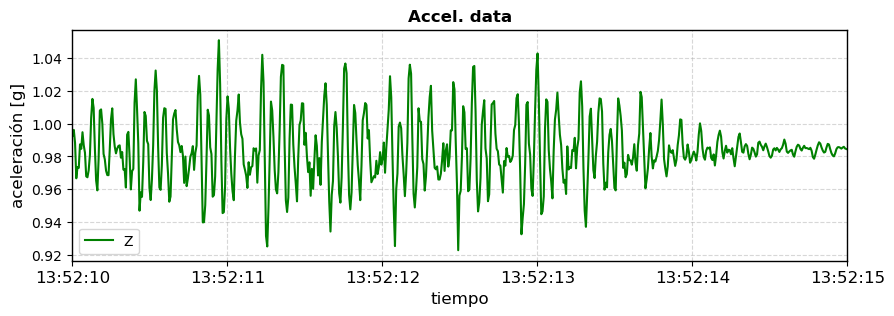

,x,y,z,data_block
datetime,,,,
2025-03-01 13:52:10.001868,0.118637,-0.019688,0.992691,3782089
2025-03-01 13:52:10.009868,0.118164,-0.016376,0.996128,3782089
2025-03-01 13:52:10.017868,0.121002,-0.022369,0.988285,3782089
2025-03-01 13:52:10.025868,0.115242,-0.019493,0.966675,3782089
2025-03-01 13:52:10.033868,0.114441,-0.018490,0.973530,3782089
...,...,...,...,...
2025-03-01 13:52:14.961868,0.116611,-0.020573,0.984737,3782139
2025-03-01 13:52:14.969868,0.116650,-0.020405,0.985397,3782139
2025-03-01 13:52:14.977868,0.116444,-0.020741,0.985859,3782139


In [ ]:
plot_acelerometer_data(data, axes=['z'], min_date='2025-03-01 13:52:10', max_date='2025-03-01 13:52:15')